In [ ]:
#packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel('Win_Prediction_Data.xlsx',header=0)

In [ ]:
df.head()

,Client Category,Solution Type,Deal Date,Sector,Location,VP Name,Manager Name,Deal Cost,Deal Status Code
0,Telecom,Solution 7,2012-03-27,Sector 24,L5,Ekta Zutshi,Gopa Trilochana,150000.00,Won
1,Telecom,Solution 7,2012-09-25,Sector 24,L5,Ekta Zutshi,Gopa Trilochana,744705.88,Won
2,Internal,Solution 59,2011-08-01,Sector 20,Others,Ekta Zutshi,Russell Dahlen,60000.00,Lost
3,Internal,Solution 59,2011-04-28,Sector 20,Others,Ekta Zutshi,Russell Dahlen,60000.00,Lost
4,Internal,Solution 32,2011-06-03,Sector 20,Others,Ekta Zutshi,Russell Dahlen,80882.35,Lost


In [ ]:
df.shape

(10061, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10061 entries, 0 to 10060
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Client Category   9982 non-null   object        
 1   Solution Type     10061 non-null  object        
 2   Deal Date         10061 non-null  datetime64[ns]
 3   Sector            10061 non-null  object        
 4   Location          10061 non-null  object        
 5   VP Name           10061 non-null  object        
 6   Manager Name      10061 non-null  object        
 7   Deal Cost         10061 non-null  float64       
 8   Deal Status Code  10061 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 707.5+ KB


This is our dataframe and we need to predict Deal Status Code.

# Data Preprocessing

As our data frame contains categorical variables, we will start with converting them into upper case and removing extra space in cells. 

In [ ]:
df.columns

Index(['Client Category', 'Solution Type', 'Deal Date', 'Sector', 'Location',
       'VP Name', 'Manager Name', 'Deal Cost', 'Deal Status Code'],
      dtype='object')

In [ ]:
categorical_colnames = ['Client Category', 'Solution Type', 'Sector', 'Location', 'VP Name',
       'Manager Name', 'Deal Status Code']

In [ ]:
for i in categorical_colnames:
    df[i]= df[i].str.upper()

In [ ]:
for i in categorical_colnames:
    df[i] = df[i].str.strip()

Now let us check for duplicate values.

In [ ]:
df.duplicated().sum()

14

We have found 14 duplicate values and we will drop them.

In [ ]:
df.drop_duplicates(keep = "first",inplace=True)

Now let me check for missing values.

In [ ]:
df.isnull().sum()

Client Category     79
Solution Type        0
Deal Date            0
Sector               0
Location             0
VP Name              0
Manager Name         0
Deal Cost            0
Deal Status Code     0
dtype: int64

Ok there are 79 missing values in Client Category. Let me check if there are any other unusual values(like "?","-" etc.). 

In [ ]:
for i in categorical_colnames:
    print({i: df[i].unique()})

{'Client Category': array(['TELECOM', 'INTERNAL', 'GOVT', 'CONSUMER GOOD',
       'INTERNATIONAL BANK', 'DOMESTIC PUBLIC BANK', 'FINANCE',
       'MANUFACTURING', 'SERVICES_BASED', 'RESEARCH DEVELOPMENT',
       'OTHERS', 'HOSPITALITY', 'CONSULTING', 'RETAIL_MARKET', 'ENERGY',
       'DOMESTIC PRIVATE BANK', 'INDUSTRIES', 'TECH', 'HEALTHCARE',
       'ELECTRONICS', 'DOMESTIC BANK', 'AUTOMOBILES', 'MEDICAL',
       'INFRASTRUCTURE', 'PHARMA', 'POWER IND', 'HOLDING', 'LOGISTICS',
       'INSURANCE', 'PAYMENT', 'GOVT BANK SPECIAL', 'MANAGEMENT',
       'MEDIA_JOURNAL', 'INTERNATIONAL ORG', 'REAL ESTATE', nan,
       'TAX_AUDIT', 'SHARE_MARKET', 'KNOWLEDGE', 'AIRPLINE', 'E-COMMERCE'],
      dtype=object)}
{'Solution Type': array(['SOLUTION 7', 'SOLUTION 59', 'SOLUTION 32', 'SOLUTION 42',
       'SOLUTION 6', 'SOLUTION 20', 'SOLUTION 37', 'SOLUTION 31',
       'SOLUTION 39', 'SOLUTION 3', 'SOLUTION 30', 'SOLUTION 33',
       'SOLUTION 29', 'SOLUTION 40', 'SOLUTION 14', 'SOLUTION 67',
      

In [ ]:
df["Deal Cost"].describe()

count    1.004700e+04
mean     7.672963e+05
std      1.620881e+06
min      0.000000e+00
25%      1.891176e+05
50%      3.823529e+05
75%      7.647059e+05
max      3.676471e+07
Name: Deal Cost, dtype: float64

There is not any unusual values except NA in Client Category. Only 79 NA values and we are going to drop them because we still left with great amount of data.

In [ ]:
df = df.dropna()

We will also drop Deal Date column because it is not of our use.

In [ ]:
df=df.drop(["Deal Date"],axis=1)

Let me also map our target variable.

In [ ]:
df["Deal Status Code"]=df["Deal Status Code"].map({"WON":1,"LOST":0})

In [ ]:
df.head()

,Client Category,Solution Type,Sector,Location,VP Name,Manager Name,Deal Cost,Deal Status Code
0,TELECOM,SOLUTION 7,SECTOR 24,L5,EKTA ZUTSHI,GOPA TRILOCHANA,150000.00,1
1,TELECOM,SOLUTION 7,SECTOR 24,L5,EKTA ZUTSHI,GOPA TRILOCHANA,744705.88,1
2,INTERNAL,SOLUTION 59,SECTOR 20,OTHERS,EKTA ZUTSHI,RUSSELL DAHLEN,60000.00,0
3,INTERNAL,SOLUTION 59,SECTOR 20,OTHERS,EKTA ZUTSHI,RUSSELL DAHLEN,60000.00,0
4,INTERNAL,SOLUTION 32,SECTOR 20,OTHERS,EKTA ZUTSHI,RUSSELL DAHLEN,80882.35,0


# EDA

First we are going to see target variable distribution for each category in categorical variables. So, in below code i have used estimator as mean which will indicate proportion of target 1(as our target variable is binary) in each category. If we get similar proportion for all categories in any particular categorical variable, it indicates that categorical variable is not much useful in predicting target variable and we will not select that variable in our model.

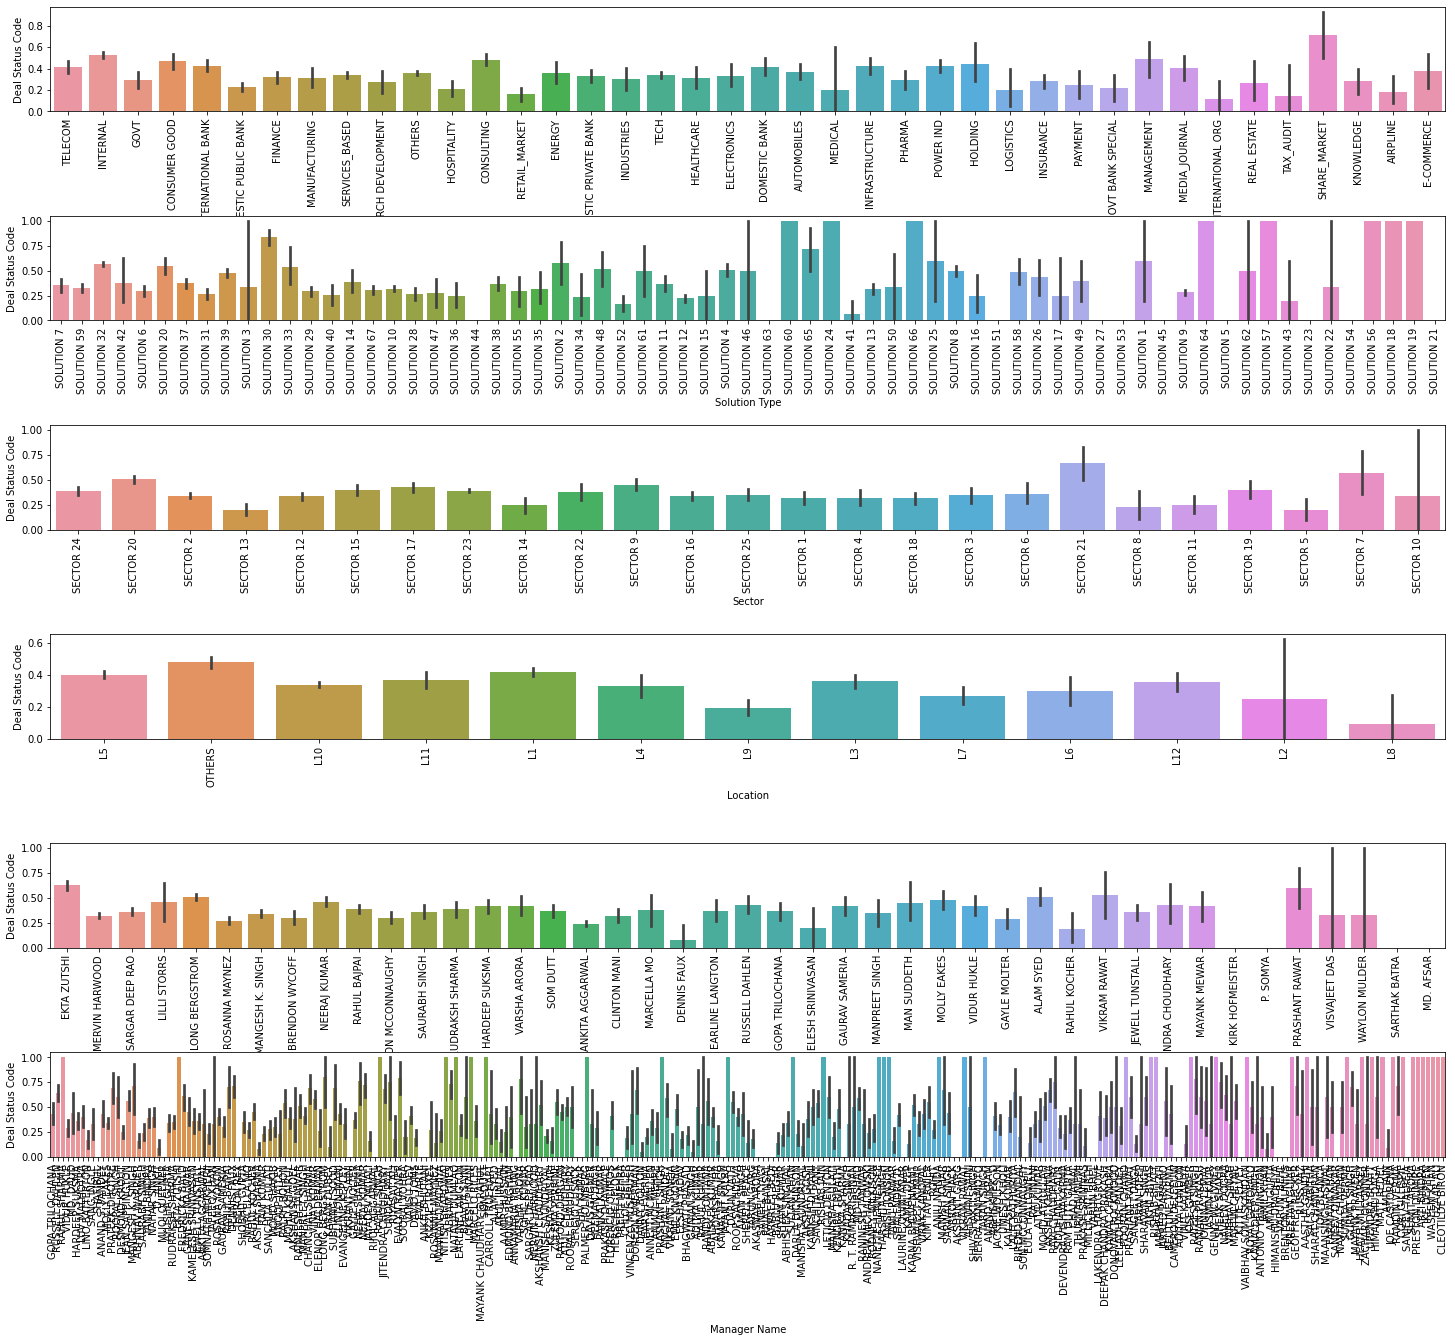

In [ ]:
plt.figure(figsize=(25,25))
for i in range(len(categorical_colnames)-1):
    plt.subplot(len(categorical_colnames),1,i+1)
    sns.barplot(x=categorical_colnames[i],y="Deal Status Code",data = df,estimator = np.mean)
    plt.xticks(rotation=90)
plt.subplots_adjust(hspace=1)
plt.show()

As we can see that proportions of target variable are not constant within any categorical variable. So we are going to include this all categorical variables in our model.

Let me check for distribution of continous variable Deal Cost.

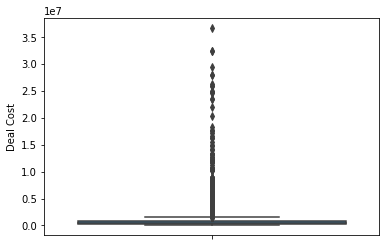

In [ ]:
sns.boxplot(y=df["Deal Cost"])

Too wide range to visualize box plot. Let me reduce its range by taking square root.

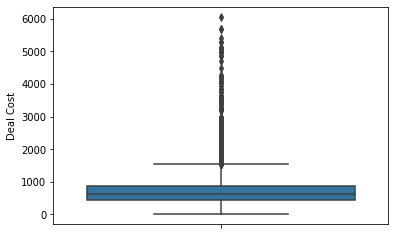

In [ ]:
sns.boxplot(y=np.sqrt(df["Deal Cost"]))

Some classification algorithm like logistic regression get affected by extreme values so i am going to replace extreme values with 4500.

In [ ]:
df["Deal Cost"] = np.sqrt(df["Deal Cost"])

In [ ]:
df.loc[df[df["Deal Cost"]>4500].index,["Deal Cost"]] = 4500

Let me check distribution of Deal Cost variable for each category of target variable.

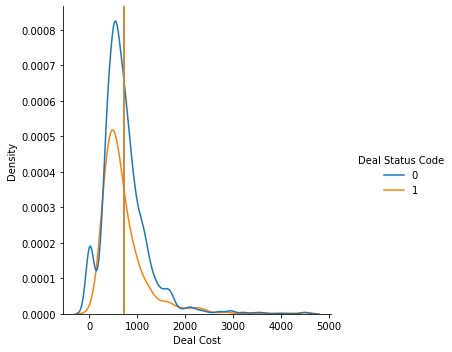

In [ ]:
t=df.groupby("Deal Status Code").agg({"Deal Cost":["mean"]}).values  # to get mean value of Deal Cost for each of the target categories
sns.displot(df, x="Deal Cost", hue="Deal Status Code",kind="kde")
plt.axvline(t[0] ,color = "blue") # t[0] is mean of Deal Cost for target category 0
plt.axvline(t[1],color = "orange") #t[1] is mean of Deal Cost for target category 1

From above distribution we can see that Deal Cost has almost identical distribution for each of the target categories. So it seems that Deal Cost is not going to be useful in classify target variable.

# Encoding

There are many Encoding techniques like dummy variable, label encoding , mean encoding etc. But here, i think mean encoding will make more sense. As we have seen in EDA that proportions(or you can say probability of getting Target 1 which is shown by mean value in EDA graphs) are not similar. So mean encoding can help to capture this relationship. High values for categories which has high proportion of target 1 and low values for categories which has low proportion of target 1. 

We can also use dummy but it will add many new dimensions, which will lead to more complexity.

Where as label encoding labels categories based on alphabetical order, It will produce misleading result for certain algorithms. If our categories have something rank like order and they have adjusted themselves alphabetically correspond to ranks, We could have considered label encoding. 

In [80]:
mean_colnames = ['Client Category', 'Solution Type', 'Sector', 'Location', 'VP Name','Manager Name']

In [81]:
#mean encoding
for i in mean_colnames:
    Mean_Values = df.groupby([i])['Deal Status Code'].mean().to_dict() #This will make dictionary in which key will be category and value will be mean corresponding to that category.
    df[i] =  df[i].map(Mean_Values) #this will map categorical variables based on its dictionary generated in above step.

In [82]:
df.head()

,Client Category,Solution Type,Sector,Location,VP Name,Manager Name,Deal Cost,Deal Status Code
0,0.414110,0.352273,0.386861,0.402235,0.625455,0.428571,387.298335,1
1,0.414110,0.352273,0.386861,0.402235,0.625455,0.428571,862.963429,1
2,0.523777,0.322176,0.505852,0.480344,0.625455,0.640288,244.948974,0
3,0.523777,0.322176,0.505852,0.480344,0.625455,0.640288,244.948974,0
4,0.523777,0.567719,0.505852,0.480344,0.625455,0.640288,284.398224,0


## Model Making
I am going to apply several classification algorithms. I will create base model for each algorithm and also KFold cross validate model. KFold cross validation requires huge resources but here our dataset is small that's why i am going to create KFold validated model. Apart from KFold cross validation, i have not applied any tuning techniques so our final model will be base model or KFold cross validated model.

And also remember that if your KFold cross validated model does not improve accuracy significantly compare to base model then it is not advisable to use KFold cross validated model.

Creating X and Y

In [83]:
X = df.values[:,0:6] # we have converted df into array so that we can easily process data
Y = df.values[:,-1]  

As of now, We have also dropped Deal Cost as it was seeming unuseful variable as we have seen in EDA. 

Scaling : scaling is not required in this case as our all independent variables ranges from 0 to 1 but still we would apply StandardScaler as practice.

In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [85]:
from sklearn.model_selection import train_test_split

X_train , X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=10)

1)      **LOGISTIC REGRESSION**

---------Base Logistic Regression  

In [86]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train,Y_train)
Y_pred = classifier.predict(X_test)    

In [87]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[1587  283]
 [ 638  483]]
Classification report :
              precision    recall  f1-score   support

         0.0       0.71      0.85      0.78      1870
         1.0       0.63      0.43      0.51      1121

    accuracy                           0.69      2991
   macro avg       0.67      0.64      0.64      2991
weighted avg       0.68      0.69      0.68      2991

0.6920762286860582


---------KFold cross validated Logistic Regression

In [88]:
from sklearn.model_selection import KFold
kfold_cv = KFold(n_splits=10)   # 10 is genearlly preferable value for small dataset

from sklearn.model_selection import cross_val_score
kfold_cv_result = cross_val_score(estimator = classifier,X=X_train,y=Y_train,cv = kfold_cv)

print(kfold_cv_result)  # This will print accuracy value for each fold
print(kfold_cv_result.mean()) # This will print average accuracy value

[0.6991404  0.67908309 0.71776504 0.70630372 0.71919771 0.71633238
 0.69054441 0.70014347 0.71449067 0.71162123]
0.7054622142378512


In [89]:
for train_value,test_value in kfold_cv.split(X_train):
    classifier.fit(X_train[train_value],Y_train[train_value]).predict(X_train[test_value])
Y_pred = classifier.predict(X_test) # this will predict on X_test by using cross validated model

In [90]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[1588  282]
 [ 637  484]]
Classification report :
              precision    recall  f1-score   support

         0.0       0.71      0.85      0.78      1870
         1.0       0.63      0.43      0.51      1121

    accuracy                           0.69      2991
   macro avg       0.67      0.64      0.64      2991
weighted avg       0.68      0.69      0.68      2991

0.692744901370779


2) **KNeighbors**

---------Base KNeighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=25,metric="minkowski",p=2)  # 25 just selected randomly, to get best value we need to try many values 
classifier.fit(X_train,Y_train)
Y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[1550  320]
 [ 601  520]]
Classification report :
              precision    recall  f1-score   support

         0.0       0.72      0.83      0.77      1870
         1.0       0.62      0.46      0.53      1121

    accuracy                           0.69      2991
   macro avg       0.67      0.65      0.65      2991
weighted avg       0.68      0.69      0.68      2991

0.6920762286860582


---------KFold cross validated KNeighbors

In [ ]:
from sklearn.model_selection import KFold
kfold_cv = KFold(n_splits=10)

from sklearn.model_selection import cross_val_score
kfold_cv_result = cross_val_score(estimator = classifier,X=X_train,y=Y_train,cv = kfold_cv)

print(kfold_cv_result)
print(kfold_cv_result.mean())

[0.7234957  0.68338109 0.7234957  0.69770774 0.72206304 0.73782235
 0.69340974 0.70301291 0.7302726  0.72166428]
0.7136325142958155


In [ ]:
for train_value,test_value in kfold_cv.split(X_train):
    classifier.fit(X_train[train_value],Y_train[train_value]).predict(X_train[test_value])
Y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[1543  327]
 [ 588  533]]
Classification report :
              precision    recall  f1-score   support

         0.0       0.72      0.83      0.77      1870
         1.0       0.62      0.48      0.54      1121

    accuracy                           0.69      2991
   macro avg       0.67      0.65      0.65      2991
weighted avg       0.68      0.69      0.68      2991

0.6940822467402207


3) **SVM**

---------Base SVM

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel="rbf",C=1,gamma=0.01) # just selected randomly C and gamma, for optimum value we need to try several values
classifier.fit(X_train,Y_train)
Y_pred=classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[1724  146]
 [ 740  381]]
Classification report :
              precision    recall  f1-score   support

         0.0       0.70      0.92      0.80      1870
         1.0       0.72      0.34      0.46      1121

    accuracy                           0.70      2991
   macro avg       0.71      0.63      0.63      2991
weighted avg       0.71      0.70      0.67      2991

0.7037780006686727


---------KFold cross validated SVM

In [ ]:
from sklearn.model_selection import KFold
kfold_cv = KFold(n_splits=10)

from sklearn.model_selection import cross_val_score
kfold_cv_result = cross_val_score(estimator = classifier,X=X_train,y=Y_train,cv = kfold_cv)

print(kfold_cv_result)
print(kfold_cv_result.mean())

[0.6991404  0.67335244 0.72636103 0.69054441 0.7234957  0.70200573
 0.68767908 0.69440459 0.71879484 0.71162123]
0.7027399456532911


In [ ]:
for train_value,test_value in kfold_cv.split(X_train):
    classifier.fit(X_train[train_value],Y_train[train_value]).predict(X_train[test_value])
Y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[1722  148]
 [ 740  381]]
Classification report :
              precision    recall  f1-score   support

         0.0       0.70      0.92      0.80      1870
         1.0       0.72      0.34      0.46      1121

    accuracy                           0.70      2991
   macro avg       0.71      0.63      0.63      2991
weighted avg       0.71      0.70      0.67      2991

0.7031093279839519


4) **Random Forest**

---------Base Random Forest

In [94]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100) # 100 is selected randomly
classifier.fit(X_train,Y_train)
Y_pred=classifier.predict(X_test)

In [95]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[1637  233]
 [ 458  663]]
Classification report :
              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83      1870
         1.0       0.74      0.59      0.66      1121

    accuracy                           0.77      2991
   macro avg       0.76      0.73      0.74      2991
weighted avg       0.77      0.77      0.76      2991

0.7689735874289535


---------KFold cross validated Random Forest

In [96]:
from sklearn.model_selection import KFold
kfold_cv = KFold(n_splits=10)

from sklearn.model_selection import cross_val_score
kfold_cv_result = cross_val_score(estimator = classifier,X=X_train,y=Y_train,cv = kfold_cv)

print(kfold_cv_result)
print(kfold_cv_result.mean())

[0.75644699 0.73352436 0.77507163 0.79226361 0.73065903 0.76647564
 0.75644699 0.78335725 0.79053085 0.77905308]
0.7663829428619586


In [97]:
for train_value,test_value in kfold_cv.split(X_train):
    classifier.fit(X_train[train_value],Y_train[train_value]).predict(X_train[test_value])
Y_pred = classifier.predict(X_test)

In [98]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

cfm = confusion_matrix(Y_test,Y_pred)
print(cfm)
print("Classification report :")

print(classification_report(Y_test,Y_pred))

acc= accuracy_score(Y_test,Y_pred)
print(acc)

[[1603  267]
 [ 472  649]]
Classification report :
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81      1870
         1.0       0.71      0.58      0.64      1121

    accuracy                           0.75      2991
   macro avg       0.74      0.72      0.72      2991
weighted avg       0.75      0.75      0.75      2991

0.7529254429956537


# Model Selection

Remember that our main goal is to get high recall value for target 1 and simultaneously high accuracy. Because winning of bid will generate revenue for company and that's why we need high racall for target 1 with balance accuracy.

So the best model among models we have tried is Base Random Forest. It is giving good recall value for target 1 and also good accuracy. 